In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd
import pickle

from pqcd.utils import (
    rcparams,
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    nsat
    )

from cmcrameri import cm

plt.rcParams.update(rcparams)

In [2]:
# The maximised likelihood marginalised over X
def maximised_likelihood_Xmarg(e0, p0, n0, N=1000):

    weight = np.zeros(N)

    for i in range(N):
        
        # Log-linear distribution for X
        X = np.random.uniform(np.log(1/2), np.log(2))
        
        # For each X assign 0 or 1 for given point
        weight[i] = int(pqcd.maximised_likelihood(e0=e0,p0=p0,n0=n0,X=np.exp(X)))

    return weight.mean()

In [3]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values at low density
# http://arxiv.org/abs/2111.05350
chiEFT_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

Initialise a instance of the `pQCD_constraints` class with particular values for the low and high density predictions:

In [4]:
muL, nL, pL = chiEFT_values['stiff']
muH = 2.6

constraints = pqcd.constraints(muL, nL, pL, muH, X=2)

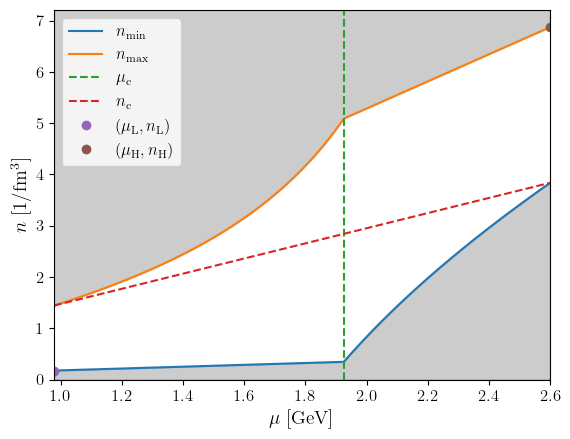

In [5]:
mu_array = np.linspace(muL, muH, 1000)

# There are functions to plot the constraints in the chemical potential vs
# baryon number density plane...
fig, ax = constraints.plot_mu_n(mu_array)

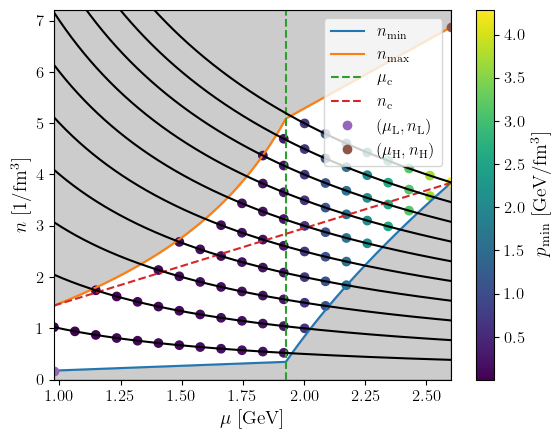

In [6]:
fig, ax = constraints.plot_mu_n(mu_array)

# Overplot some constant-enthalpy lines
h_array = np.linspace(1, 10, 10)

for h in h_array:
    ax.plot(mu_array, h/mu_array, c='k')

# Indicate the minimum pressure along each constant-enthalpy line
reduced_mu_array = np.linspace(muL, muH, 20)
reduced_n_array = np.outer(h_array, 1/reduced_mu_array).flatten()

reduced_mu_array_scatter = np.outer(np.ones(len(h_array)), reduced_mu_array).flatten()

mask = (
    (constraints.nmin(reduced_mu_array_scatter) < reduced_n_array) & 
    (reduced_n_array < constraints.nmax(reduced_mu_array_scatter))
)

im = ax.scatter(
    reduced_mu_array_scatter[mask],
    reduced_n_array[mask],
    c=constraints.pmin(reduced_mu_array_scatter)[mask], 
    cmap='viridis'
    )

cbar = fig.colorbar(im, ax=ax)

cbar.set_label(r'$p_\mathrm{min}$ [GeV/fm$^3$]')

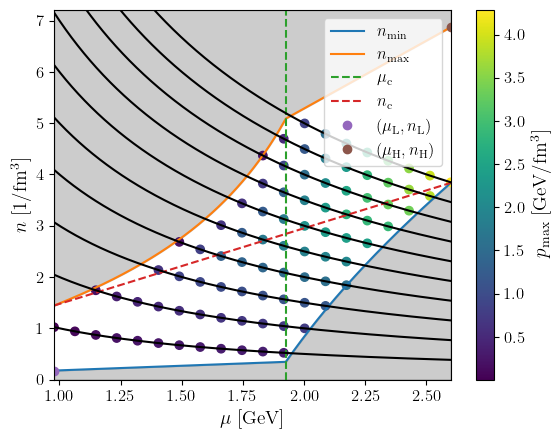

In [7]:
fig, ax = constraints.plot_mu_n(mu_array)

# Overplot some constant-enthalpy lines
h_array = np.linspace(1, 10, 10)

for h in h_array:
    ax.plot(mu_array, h/mu_array, c='k')

# Indicate the maximum pressure along each constant-enthalpy line
reduced_mu_array = np.linspace(muL, muH, 20)
reduced_n_array = np.outer(h_array, 1/reduced_mu_array).flatten()

reduced_mu_array_scatter = np.outer(np.ones(len(h_array)), reduced_mu_array).flatten()

mask = (
    (constraints.nmin(reduced_mu_array_scatter) < reduced_n_array) & 
    (reduced_n_array < constraints.nmax(reduced_mu_array_scatter))
)

im = ax.scatter(
    reduced_mu_array_scatter[mask],
    reduced_n_array[mask],
    c=constraints.pmax(reduced_mu_array_scatter, reduced_n_array)[mask], 
    cmap='viridis'
    )

cbar = fig.colorbar(im, ax=ax)

cbar.set_label(r'$p_\mathrm{max}$ [GeV/fm$^3$]')

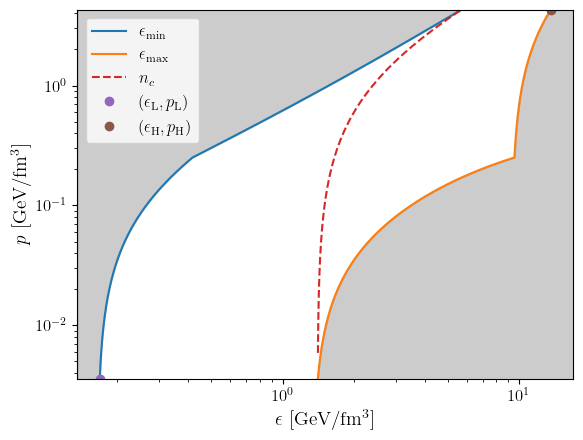

In [8]:
# ... and in the energy density vs pressure plane
fig, ax = constraints.plot_epsilon_p(mu_array)

In [9]:
collated_eos = pd.read_csv('../data/eos-draws-default.csv')
collated_ntov = to_nucleons_per_cubic_femtometre(collated_eos['rhoc(M@Mmax)'])/nsat

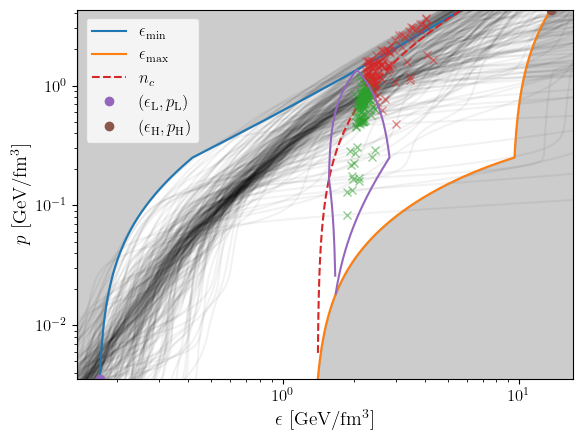

In [10]:
fig, ax = constraints.plot_epsilon_p(mu_array)

# Overplot some EOS draws, and visualise the pQCD likelihood when applied at n0
n0 = 10 # [nsat]

energy_density_at_n0 = np.loadtxt(f'../data/quantities_at_fixed_n/energy_density_{n0:02}nsat.dat')
pressure_at_n0 = np.loadtxt(f'../data/quantities_at_fixed_n/pressure_{n0:02}nsat.dat')

# A list of allowed EOSs will be useful
good_eos_list = []

N_samp = 250
for eos, eps_n0, p_n0 in zip(collated_eos.eos[:N_samp], energy_density_at_n0[:N_samp], pressure_at_n0[:N_samp]):

    eos = int(eos)
    df = pd.read_csv(f'../data/eos-draws-default/eos-draw-{eos:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

    ax.plot(
        energy_density, 
        pressure, 
        alpha=0.05, 
        c='k',
        zorder=0.1
        )
    
    eos_mask = number_density < n0*nsat

    allowed = pqcd.maximised_likelihood(e0=eps_n0, p0=p_n0, n0=n0*nsat, X=2)
    if allowed:
        good_eos_list.append((
            np.concatenate((pressure.values[eos_mask], [p_n0])), 
            np.concatenate((energy_density.values[eos_mask], [eps_n0])),
            np.concatenate((number_density.values[eos_mask], [n0*nsat]))
            ))

    ax.plot(
        eps_n0,
        p_n0,
        'x',
        c='C2' if allowed else 'C3',
        alpha=0.5
        )

# Indicate the allowed region at this density
x1 = pqcd.epsilon_func(mu_array, n0*nsat, constraints.pmax(mu_array, n0*nsat))
x2 = pqcd.epsilon_func(mu_array, n0*nsat, constraints.pmin(mu_array))
mask = x1 < x2

ax.plot(
    x1[mask], 
    constraints.pmax(mu_array, n0*nsat)[mask], 
    c='C4'
    )

_ = ax.plot(
    x2[mask], 
    constraints.pmin(mu_array)[mask], 
    c='C4'
    )

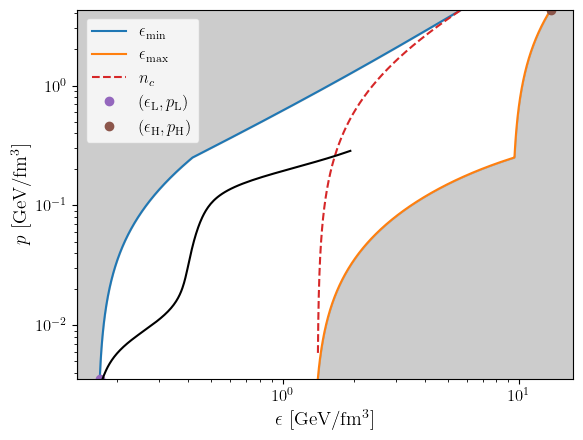

In [11]:
i = 7
pressure, energy_density, number_density = good_eos_list[i]
chemical_potential = (energy_density+pressure)/number_density

fig, ax = constraints.plot_epsilon_p(mu_array)

_ = ax.plot(
    energy_density,
    pressure,
    'k'
    )

In [12]:
# The area under the curve:
pqcd.pressure_integral(chemical_potential, number_density, pressure[0])[-1]

0.2832773769748958

In [13]:
# Should be equal to the pressure at the end of the curve:
pressure[-1]

0.28505839004894407

In [14]:
# And the requested number density:
n0*nsat

1.6

In [15]:
# Should equal the final number density of the curve:
number_density[-1]

1.6

In [16]:
# We effectively have new low-density values. This will inform the available 
# parameter space for higher densities
new_constraints = pqcd.constraints(chemical_potential[-1], number_density[-1], pressure[-1], muH, X=2)
new_mu_array = np.linspace(chemical_potential[-1], muH, 1000)

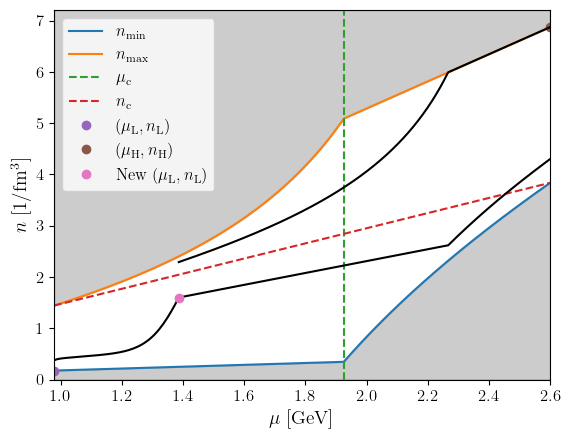

In [17]:
fig, ax = constraints.plot_mu_n(mu_array)

ax.plot(
    chemical_potential,
    number_density,
    'k'
    )

ax.plot(new_mu_array, new_constraints.nmin(new_mu_array), c='k')
ax.plot(new_mu_array, new_constraints.nmax(new_mu_array), c='k')

ax.plot(
    new_constraints.muL, 
    new_constraints.nL, 
    'o', 
    c='C6', 
    label='New $(\mu_\mathrm{L}, n_\mathrm{L})$'
    )

_ = ax.legend()

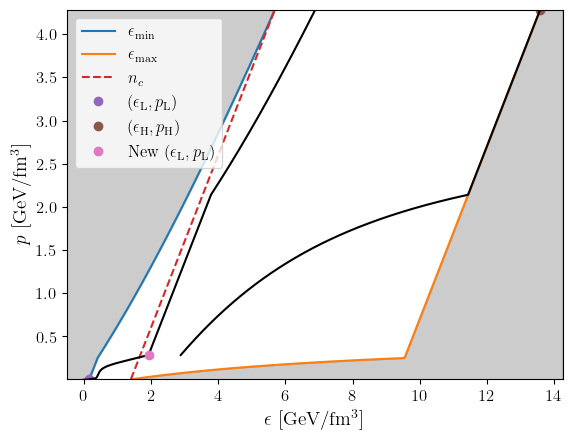

In [18]:
fig, ax = constraints.plot_epsilon_p(mu_array, log=False)

ax.plot(
    energy_density,
    pressure,
    'k'
    )

ax.plot(
    new_constraints.epsilon_min(new_mu_array), 
    new_constraints.pmax(new_mu_array, new_constraints.nmin(new_mu_array)), 
    c='k',
    )
ax.plot(
    new_constraints.epsilon_max(new_mu_array), 
    new_constraints.pmin(new_mu_array), 
    c='k',
    )

ax.plot(
    new_constraints.epsilonL, 
    new_constraints.pL, 
    'o', 
    c='C6', 
    label='New $(\epsilon_\mathrm{L}, p_\mathrm{L})$'
    )

_ = ax.legend()

### Inspect the EOS extensions used in the marginalised pQCD likelihood

In [19]:
with open('../data/eos-extensions/eos_extensions_s-G-1p25-0p25_l-U-1-20_meancs2-G-0.3-0.3_pQCD-25-40.pickle', 'rb') as f:
    eos_extensions = pickle.load(f)

eos_extensions['n'] = (eos_extensions['p'] + eos_extensions['e'])/eos_extensions['mu']

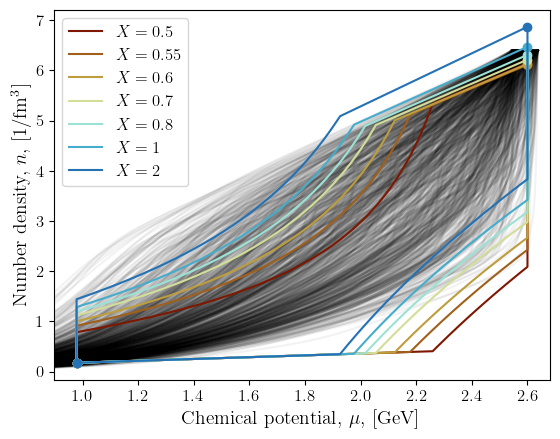

In [20]:
X_list = [0.5, 0.55, 0.6, 0.7, 0.8, 1, 2]

muL, nL, pL = chiEFT_values['stiff']
muH = 2.6

mu_array = np.linspace(muL, muH, 1000)

fig, ax = plt.subplots()

for i, X in enumerate(X_list):

    constraints = pqcd.constraints(muL, nL, pL, muH, X=X)

    c = cm.roma(i/len(X_list))

    nmin = constraints.nmin(mu_array)
    nmax = constraints.nmax(mu_array)

    ax.plot(
        np.concatenate((mu_array, [constraints.muH])), 
        np.concatenate((nmin, [constraints.nH])),
        c=c,
        label=f'$X = {X}$'
        )
    
    ax.plot(
        np.concatenate(([constraints.muL], mu_array)), 
        np.concatenate(([constraints.nL], nmax)),
        c=c,
        )

    ax.plot(
        constraints.muL,
        constraints.nL, 
        'o', 
        c=c, 
        )
    
    ax.plot(
        constraints.muH, 
        constraints.nH, 
        'o', 
        c=c, 
        )
    
xlim = ax.get_xlim()
ylim = ax.get_ylim()

N_samp = 1000
for index, eos in eos_extensions.sample(N_samp).iterrows():
    ax.plot(eos.mu, eos.n, 'k', alpha=0.05, zorder=0.01)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(loc='upper left')
    
ax.set_xlabel('Chemical potential, $\mu$, [GeV]')
_ = ax.set_ylabel('Number density, $n$, [1/fm$^3$]')

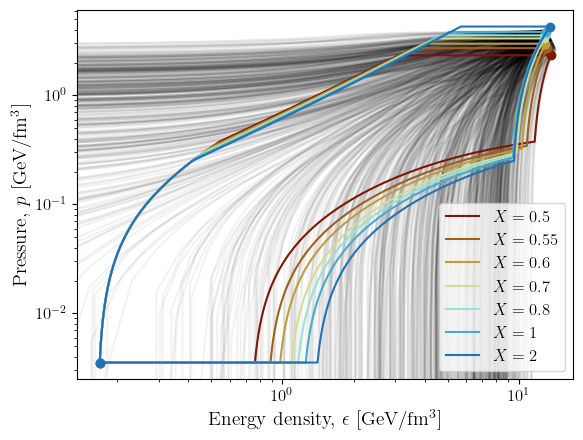

In [21]:
X_list = [0.5, 0.55, 0.6, 0.7, 0.8, 1, 2]

muL, nL, pL = chiEFT_values['stiff']
muH = 2.6

mu_array = np.linspace(muL, muH, 1000)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

for i, X in enumerate(X_list):

    constraints = pqcd.constraints(muL, nL, pL, muH, X=X)

    c = cm.roma(i/len(X_list))

    epsilon_min = constraints.epsilon_min(mu_array)
    p_max = constraints.pmax(mu_array, constraints.nmin(mu_array))
    
    epsilon_max = constraints.epsilon_max(mu_array)
    p_min = constraints.pmin(mu_array)

    ax.plot(
        np.concatenate((epsilon_min, [constraints.epsilonH])), 
        np.concatenate((p_max, [constraints.pH])),
        c=c,
        label=f'$X = {X}$'
        )
    
    ax.plot(
        np.concatenate(([constraints.epsilonL], epsilon_max)), 
        np.concatenate(([constraints.pL], p_min)),
        c=c,
        )

    ax.plot(
        constraints.epsilonL, 
        constraints.pL, 
        'o', 
        c=c, 
        )
    
    ax.plot(
        constraints.epsilonH, 
        constraints.pH, 
        'o', 
        c=c, 
        )
    
xlim = ax.get_xlim()
ylim = ax.get_ylim()

N_samp = 1000
for index, eos in eos_extensions.sample(N_samp).iterrows():
    ax.plot(eos.e, eos.p, 'k', alpha=0.05, zorder=0.01)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(loc='lower right')
    
ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

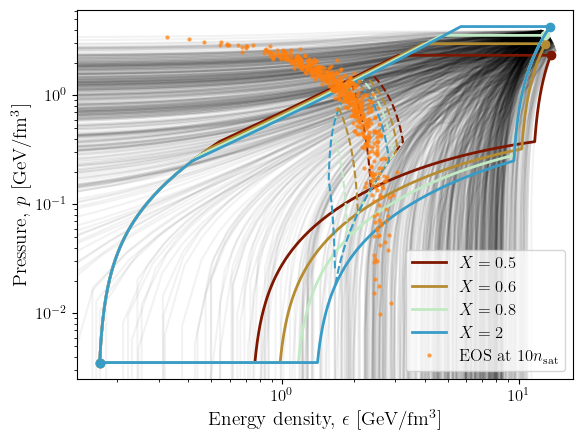

In [22]:
X_list = [0.5, 0.6, 0.8, 2] # [0.5, 0.55, 0.6, 0.7, 0.8, 1, 2]

n0 = 10*nsat

muL, nL, pL = chiEFT_values['stiff']
muH = 2.6

mu_array = np.linspace(muL, muH, 1000)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

for i, X in enumerate(X_list):

    constraints = pqcd.constraints(muL, nL, pL, muH, X=X)

    c = cm.roma(i/len(X_list))

    epsilon_min = constraints.epsilon_min(mu_array)
    p_max = constraints.pmax(mu_array, constraints.nmin(mu_array))
    
    epsilon_max = constraints.epsilon_max(mu_array)
    p_min = constraints.pmin(mu_array)

    ax.plot(
        np.concatenate((epsilon_min, [constraints.epsilonH])), 
        np.concatenate((p_max, [constraints.pH])),
        c=c,
        label=f'$X = {X}$',
        lw=2
        )
    
    ax.plot(
        np.concatenate(([constraints.epsilonL], epsilon_max)), 
        np.concatenate(([constraints.pL], p_min)),
        c=c,
        lw=2
        )

    ax.plot(
        constraints.epsilonL, 
        constraints.pL, 
        'o', 
        c=c, 
        )
    
    ax.plot(
        constraints.epsilonH, 
        constraints.pH, 
        'o', 
        c=c, 
        )
    
    # Indicate the allowed region at this density
    x1 = pqcd.epsilon_func(mu_array, n0, constraints.pmax(mu_array, n0))
    x2 = pqcd.epsilon_func(mu_array, n0, constraints.pmin(mu_array))
    mask = x1 < x2 

    ax.plot(
        x1[mask], 
        constraints.pmax(mu_array, n0)[mask], 
        c=c,
        # lw=0.5,
        ls='--'
        )

    ax.plot(
        x2[mask], 
        constraints.pmin(mu_array)[mask], 
        c=c,
        # lw=0.5,
        ls='--'
        )
    
xlim = ax.get_xlim()
ylim = ax.get_ylim()

N_samp = 1000
label_added = False
for index, eos in eos_extensions.sample(N_samp).iterrows():
    ax.plot(eos.e, eos.p, 'k', alpha=0.05, zorder=0.01)
    highlight_index = np.argmin((eos.n[:-1]-n0)**2)
    if not label_added:
        label = 'EOS at $10n_\mathrm{sat}$'
        label_added = True
    else:
        label = None
    ax.plot(eos.e[highlight_index], eos.p[highlight_index], '.', markeredgewidth=0, c='C1', alpha=0.75, label=label)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(loc='lower right')
    
ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

fig.savefig('figures/marg_constraints.png', bbox_inches='tight', dpi=300)

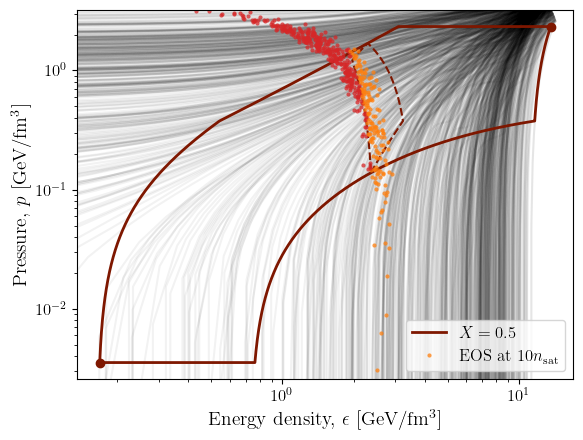

In [23]:
n0 = 10*nsat

muL, nL, pL = chiEFT_values['stiff']
X = 0.5
muH = 2.6

constraints = pqcd.constraints(muL, nL, pL, muH, X=X)

mu_array = np.linspace(muL, muH, 1000)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

c = cm.roma(0)

epsilon_min = constraints.epsilon_min(mu_array)
p_max = constraints.pmax(mu_array, constraints.nmin(mu_array))

epsilon_max = constraints.epsilon_max(mu_array)
p_min = constraints.pmin(mu_array)

ax.plot(
    np.concatenate((epsilon_min, [constraints.epsilonH])), 
    np.concatenate((p_max, [constraints.pH])),
    c=c,
    label=f'$X = {X}$',
    lw=2
    )

ax.plot(
    np.concatenate(([constraints.epsilonL], epsilon_max)), 
    np.concatenate(([constraints.pL], p_min)),
    c=c,
    lw=2
    )

ax.plot(
    constraints.epsilonL, 
    constraints.pL, 
    'o', 
    c=c, 
    )

ax.plot(
    constraints.epsilonH, 
    constraints.pH, 
    'o', 
    c=c, 
    )

# Indicate the allowed region at this density
x1 = pqcd.epsilon_func(mu_array, n0, constraints.pmax(mu_array, n0))
x2 = pqcd.epsilon_func(mu_array, n0, constraints.pmin(mu_array))
mask = x1 < x2 

ax.plot(
    x1[mask], 
    constraints.pmax(mu_array, n0)[mask], 
    c=c,
    # lw=0.5,
    ls='--'
    )

ax.plot(
    x2[mask], 
    constraints.pmin(mu_array)[mask], 
    c=c,
    # lw=0.5,
    ls='--'
    )
    
xlim = ax.get_xlim()
ylim = ax.get_ylim()

N_samp = 1000
label_added = False
for index, eos in eos_extensions.sample(N_samp).iterrows():
    ax.plot(eos.e, eos.p, 'k', alpha=0.05, zorder=0.01)
    highlight_index = np.argmin((eos.n[:-1]-n0)**2)
    allowed = pqcd.maximised_likelihood(e0=eos.e[highlight_index], p0=eos.p[highlight_index], n0=n0, X=X)
    if not label_added:
        label = 'EOS at $10n_\mathrm{sat}$'
        label_added = True
    else:
        label = None
    ax.plot(
       eos.e[highlight_index], 
       eos.p[highlight_index], 
       '.', 
       markeredgewidth=0, 
       c='C1' if allowed else 'C3', 
       alpha=0.75, 
       label=label
       )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(loc='lower right')
    
ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

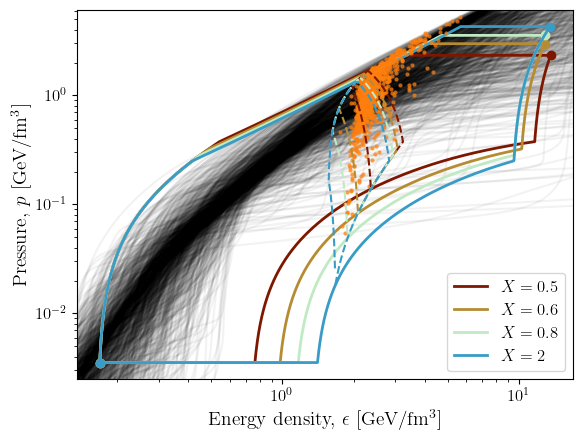

In [24]:
X_list = [0.5, 0.6, 0.8, 2] # [0.5, 0.55, 0.6, 0.7, 0.8, 1, 2]

n0 = 10*nsat

muL, nL, pL = chiEFT_values['stiff']
muH = 2.6

mu_array = np.linspace(muL, muH, 1000)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

for i, X in enumerate(X_list):

    constraints = pqcd.constraints(muL, nL, pL, muH, X=X)

    c = cm.roma(i/len(X_list))

    epsilon_min = constraints.epsilon_min(mu_array)
    p_max = constraints.pmax(mu_array, constraints.nmin(mu_array))
    
    epsilon_max = constraints.epsilon_max(mu_array)
    p_min = constraints.pmin(mu_array)

    ax.plot(
        np.concatenate((epsilon_min, [constraints.epsilonH])), 
        np.concatenate((p_max, [constraints.pH])),
        c=c,
        label=f'$X = {X}$',
        lw=2
        )
    
    ax.plot(
        np.concatenate(([constraints.epsilonL], epsilon_max)), 
        np.concatenate(([constraints.pL], p_min)),
        c=c,
        lw=2
        )

    ax.plot(
        constraints.epsilonL, 
        constraints.pL, 
        'o', 
        c=c, 
        )
    
    ax.plot(
        constraints.epsilonH, 
        constraints.pH, 
        'o', 
        c=c, 
        )
    
    # Indicate the allowed region at this density
    x1 = pqcd.epsilon_func(mu_array, n0, constraints.pmax(mu_array, n0))
    x2 = pqcd.epsilon_func(mu_array, n0, constraints.pmin(mu_array))
    mask = x1 < x2 

    ax.plot(
        x1[mask], 
        constraints.pmax(mu_array, n0)[mask], 
        c=c,
        # lw=0.5,
        ls='--',
        zorder=10
        )

    ax.plot(
        x2[mask], 
        constraints.pmin(mu_array)[mask], 
        c=c,
        # lw=0.5,
        ls='--',
        zorder=10
        )
    
xlim = ax.get_xlim()
ylim = ax.get_ylim()

energy_density_at_n0 = np.loadtxt(f'../data/quantities_at_fixed_n/energy_density_10nsat.dat')
pressure_at_n0 = np.loadtxt(f'../data/quantities_at_fixed_n/pressure_10nsat.dat')

N_samp = 1000
for eos, eps_n0, p_n0 in zip(collated_eos.eos[:N_samp], energy_density_at_n0[:N_samp], pressure_at_n0[:N_samp]):

    eos = int(eos)
    df = pd.read_csv(f'../data/eos-draws-default/eos-draw-{eos:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

    ax.plot(
        energy_density, 
        pressure, 
        alpha=0.05, 
        c='k',
        zorder=0.1
        )
    
    ax.plot(
        eps_n0, 
        p_n0, 
        '.', 
        markeredgewidth=0, 
        c='C1', # cm.devon(Xmarg_likelihood), 
        alpha=0.75, 
        label=label
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(loc='lower right')
    
ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

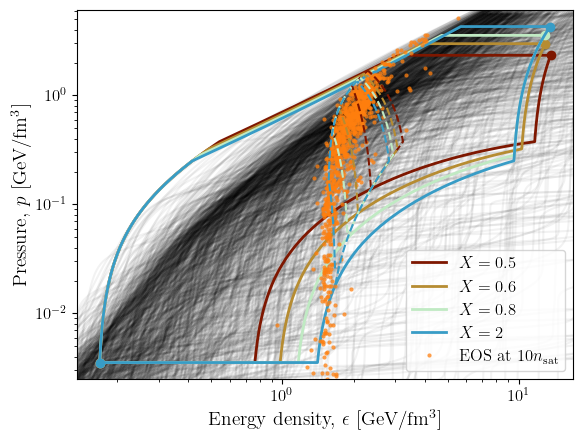

In [25]:
X_list = [0.5, 0.6, 0.8, 2] # [0.5, 0.55, 0.6, 0.7, 0.8, 1, 2]

n0 = 10*nsat

muL, nL, pL = chiEFT_values['stiff']
muH = 2.6

mu_array = np.linspace(muL, muH, 1000)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

for i, X in enumerate(X_list):

    constraints = pqcd.constraints(muL, nL, pL, muH, X=X)

    c = cm.roma(i/len(X_list))

    epsilon_min = constraints.epsilon_min(mu_array)
    p_max = constraints.pmax(mu_array, constraints.nmin(mu_array))
    
    epsilon_max = constraints.epsilon_max(mu_array)
    p_min = constraints.pmin(mu_array)

    ax.plot(
        np.concatenate((epsilon_min, [constraints.epsilonH])), 
        np.concatenate((p_max, [constraints.pH])),
        c=c,
        label=f'$X = {X}$',
        lw=2
        )
    
    ax.plot(
        np.concatenate(([constraints.epsilonL], epsilon_max)), 
        np.concatenate(([constraints.pL], p_min)),
        c=c,
        lw=2
        )

    ax.plot(
        constraints.epsilonL, 
        constraints.pL, 
        'o', 
        c=c, 
        )
    
    ax.plot(
        constraints.epsilonH, 
        constraints.pH, 
        'o', 
        c=c, 
        )
    
    # Indicate the allowed region at this density
    x1 = pqcd.epsilon_func(mu_array, n0, constraints.pmax(mu_array, n0))
    x2 = pqcd.epsilon_func(mu_array, n0, constraints.pmin(mu_array))
    mask = x1 < x2 

    ax.plot(
        x1[mask], 
        constraints.pmax(mu_array, n0)[mask], 
        c=c,
        # lw=0.5,
        ls='--',
        zorder=10
        )

    ax.plot(
        x2[mask], 
        constraints.pmin(mu_array)[mask], 
        c=c,
        # lw=0.5,
        ls='--',
        zorder=10
        )
    
xlim = ax.get_xlim()
ylim = ax.get_ylim()

energy_density_at_n0 = np.loadtxt(f'../data/quantities_at_fixed_n/energy_density_10nsat.dat')
pressure_at_n0 = np.loadtxt(f'../data/quantities_at_fixed_n/pressure_10nsat.dat')

collated_eos = pd.read_csv('../data/collated_np_all_post.csv')

N_samp = 1000
label_added = False
for eos in collated_eos.eos[:N_samp]:

    eos = int(eos)
    df = pd.read_csv(f'../data/eos-draws-default/eos-draw-{eos:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

    n0_index = np.argmin((number_density-n0)**2)

    ax.plot(
        energy_density, 
        pressure, 
        alpha=0.05, 
        c='k',
        zorder=0.1
        )
    
    if not label_added:
        label = 'EOS at $10n_\mathrm{sat}$'
        label_added = True
    else:
        label = None
    ax.plot(
        energy_density[n0_index], 
        pressure[n0_index], 
        '.', 
        markeredgewidth=0, 
        c='C1', # cm.devon(Xmarg_likelihood), 
        alpha=0.75, 
        label=label
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(loc='lower right')
    
ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')